<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/9_3_fx_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9.3　kerasを用いた深層学習（LSTM）によるドル円レート予測

　LSTMの理論を用い、本例では米セントルイス連銀から公開される日次為替レートのデータを用い、ドル円レートの予測値算出を行います。本例の理論実装では、まず定番のライブラリとして、データ取得のためのpandas_datareader、数値演算のためのnumpy、pandas、図表作成のためのmatplotlibをインポートします。そして取得したデータを基準化するためのライブラリMinMaxScalerをsklearnからインポートします。また、LSTMの実践に際し、kerasからLSTMの階層をセットアップするためのSequential、LSTM階層追加のためのLSTM、過学習の是正等の算出値を正則化するためのDropout、算出結果を結合するためのDenseを読み込みます。



In [1]:
#[1]ライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler #データ基準化のためのライブラリ
from keras.models import Sequential #LSTM階層構築のためのライブラリ
from keras.layers import LSTM #LSTM階層追加のためのライブラリ
from keras.layers import Dropout #過学習是正のためのライブラリ
from keras.layers import Dense #算出結果結合のためのライブラリ

　続いて米セントルイス連銀からドル円レートの日次データをpandas_datareaderを用いて取得します。今回のケースでは標本期間2012年1月1日から2022年12月31日の日次データを取得します。本例ではこの時系列データのデータフレームをUSDJPYと名付けます。このセルの2行目で欠損値を除去した後、3行目で変数名をリセットし、4行目で変数名を再定義します。これは、後ほど、訓練データとテストデータを統合するためです。4行目ではUSDJPY_trainというpandasデータフレームの訓練データを残した上で、USDJPY_train2という二次元配列データを作成しておきます。

In [ ]:
#[2]為替レートデータの取得とデータの整理
USDJPY=data.DataReader('DEXJPUS','fred',start="2012-01-01",end="2022-12-31")
USDJPY=USDJPY.dropna()#欠損値の除去
USDJPY.reset_index(inplace=True) #データフレーム統合のため変数名リセット
USDJPY_train = USDJPY.rename(columns={'DATE': 'Date','DEXJPUS': 'Yen_train'}) #訓練データ変数名の再定義
USDJPY_train2 = USDJPY_train.iloc[:, 1:2].values #為替レートのみのデータフレーム作成
USDJPY_train

　次のセルでは1行目で、基準化の定義を最小値0、最大値1とする指示を与え、2行目で、この定義を用いて為替レートの日次データを変換（基準化）します。3行目は確認のため、データ数を表示させます。

In [ ]:
#[3]訓練データの基準化
sc = MinMaxScaler(feature_range=(0,1)) #データ基準化の定義
Yen_scaled = sc.fit_transform(USDJPY_train2) #定義に基づく為替レートデータの基準化の実行
np.size(Yen_scaled) #行数の確認

　次のセルでは、1-2行目で2種類の訓練データX_trainとy_trainの空配列を作成します。これらの空セルの使用目的は、60日ラグ付きデータをX_trainへ、ラグなしデータをy_trainへ格納するためです。3-5行目では、2012年年初から60番目の日次データから最後の2,750番目のデータを生成して格納します。訓練期間を変更する場合は、この"60"に替わるサンプル数を任意に与えてください。7行目では、このラグ付き訓練データのX_trainのみをnp.reshapeを用いてnumpy3次元配列へ転換します。

In [4]:
#[4]訓練データの配列変換
X_train = []
y_train = []
for i in range(60, 2750):#2012年初から2022年12月末の日次データを60日刻みで反復訓練
    X_train.append(Yen_scaled[i-60:i, 0])
    y_train.append(Yen_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)#numpy配列へ変換
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))#3次元配列へ変換

　3次元配列に転換されたデータを用い、次にkerasを用いてLSTMモデルを構築します。まずmodel=Sequential()によりモデルの階層をセットアップし、続いて、model.addにより階層を段階的に追加します。model=Sequential()によるモデルのセットアップ後は、LSTMのモデルが、どのような形式であるのかを指示する必要があります。このため、まずmodel.addによる2行目の最初の階層追加ではunits=によりユニットの数を指示し、shape=において入力する訓練データが3次元であることを指定します。またreturn_sequencesにより入力と出力の次元数が同じであることを指示します。Dropoutを実行する階層では、本例では0.2とすることで、過学習是正など、算出データを正則化するために全階層の20％が除外されます。

In [ ]:
#[5]LSTM階層の初期化・追加・ドロップアウト・調節の反復
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

　訓練データと同様にドル円レートのテストデータをpandas_datareaderを用いて米セントルイス連銀から取得します。本例のテストデータは訓練データの最後の一カ月間の2022年12月1日から2022年12月31日の標本期間の日次データです。本例ではこのテスト・データのデータフレームをUSDJPY_testと名付けます。このセルの2行目で欠損値を除去した後、3行目で変数名をリセットし、4行目で変数名を再定義します。4行目ではUSDJPY_testというpandasデータフレームの訓練データを残した上で、USDJPY_test2という二次元配列データを作成しておきます。

In [6]:
#[6]テストデータの取得と整理
#USDJPY_test=data.DataReader('DEXJPUS','fred',start="2022-05-01",end="2022-05-30")
USDJPY_test=data.DataReader('DEXJPUS','fred',start="2022-12-01",end="2022-12-30")
USDJPY_test=USDJPY_test.dropna()#欠損値の除去
USDJPY_test.reset_index(inplace=True) #データフレーム統合のため変数名リセット
USDJPY_test = USDJPY_test.rename(columns={'DATE': 'Date','DEXJPUS': 'Yen_test'}) #訓練データ変数名の再定義
USDJPY_test2 = USDJPY_test.iloc[:, 1:2].values #為替レートのみのデータフレーム作成

　次のセルでは一行目で訓練データUSDJPY['Yen_train']とテストデータUSDJPY['Yen_test']を統合し、二行目でこのPandasデータフレームをnumpy配列に変換します。本例の訓練データは60営業日のタイムラグを設けているため、データの長さを60営業日カットします。3－4行目では、この統合データの行列を転置して基準化します。5-6行目ではX_testという空配列を設け、第22セルの手順と同様に、60営業日のタイムラグを持つテストデータを生成して格納します。10行目では前セルで推計されたモデルを用いて予測値の算出を行い、この結果のデータフレームをpredicted_Yen_Dollarと名付けます。この予測結果は基準化データにより算出されているため、最後の11行目でこの予測結果を再び実数値へ変換します。

In [ ]:
#[7]テストデータの取得と整理
USDJPY_total = pd.concat((USDJPY_train['Yen_train'], USDJPY_test['Yen_test']), axis = 0)#訓練データとテストデータの統合
inputs = USDJPY_total[len(USDJPY_total) - len(USDJPY_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_Yen_Dollar = model.predict(X_test)#予測値の算出
predicted_Yen_Dollar = sc.inverse_transform(predicted_Yen_Dollar)#基準化データを実数値へ再変換

　最後の第8セルでは実績値(Actual FX Rate)と予測値(Predicted FX Rate)をプロットする指示を与えます。実績値は2012年1月1日から2022年12月30日の標本期間の最後の20営業日を用い、予測期間もこの期間の予測値を採用しています。将来の予測値を求める場合は、この予測期間の20営業日のドル円レートの日次データが、1月の20営業日の為替レートの予測値として用いてください。

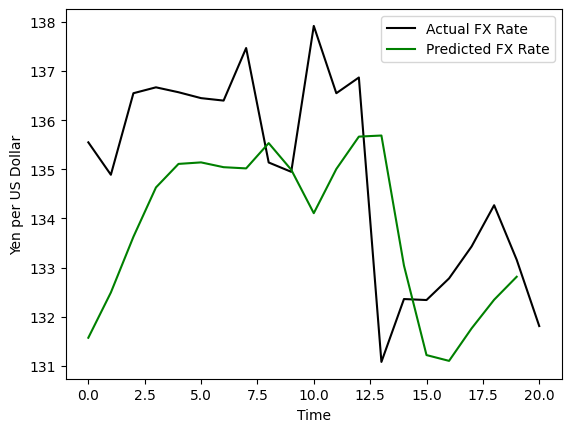

In [8]:
#[8]予測結果と実績値の可視化
plt.plot(USDJPY_test2, color = 'black', label = 'Actual FX Rate')
plt.plot(predicted_Yen_Dollar, color = 'green', label = 'Predicted FX Rate')
#plt.title('Yen Dollar Prediction by Deep Learning')
plt.xlabel('Time')
plt.ylabel('Yen per US Dollar')
plt.legend()
plt.show()